In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [3]:
df = pd.read_csv("ambient_temperature_system_failure.csv",header=0, index_col=0, parse_dates=['timestamp'])

In [4]:
import statsmodels.api as sm
from pylab import rcParams

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

In [7]:
from sklearn.cluster import KMeans 

In [8]:
from sklearn.decomposition import PCA
from scipy import stats
from collections import Counter
from sklearn.metrics import silhouette_score
from time import time

In [9]:
from sklearn.neighbors import LocalOutlierFactor

In [10]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve, auc, confusion_matrix

# I. Problem statement 

## Impact 
Ambient temperature could be important for 

* Hardware failture: 

* Unintended Human error: adjustment on the control 

## Approach

Using Anomaly detection we can have early signals when an unexpected change in ambient temperature change occurs. It helps hardware staff, office or space manager, and manufactuer to diagose and interven early to prevent any business or personal impact (e.g. unpleasant temperature, or excessive energy usage).


# II. Exploratory data analysis

We have data from July 2013 to May 14, logging at seemly 1h interval of the temperature.


In [11]:
df.shape

(7267, 1)

In [12]:
df.describe()

,value
count,7267.000000
mean,71.242433
std,4.247509
min,57.458406
25%,68.369411
50%,71.858493
75%,74.430958
max,86.223213


In [13]:
df.head(10)

,value
timestamp,
2013-07-04 00:00:00,69.880835
2013-07-04 01:00:00,71.220227
2013-07-04 02:00:00,70.877805
2013-07-04 03:00:00,68.959400
2013-07-04 04:00:00,69.283551
2013-07-04 05:00:00,70.060966
2013-07-04 06:00:00,69.279765
2013-07-04 07:00:00,69.369608
2013-07-04 08:00:00,69.166714


In [14]:
df.tail(10)

,value
timestamp,
2014-05-28 06:00:00,64.784023
2014-05-28 07:00:00,65.645874
2014-05-28 08:00:00,67.472568
2014-05-28 09:00:00,68.033080
2014-05-28 10:00:00,70.455717
2014-05-28 11:00:00,72.370206
2014-05-28 12:00:00,72.172956
2014-05-28 13:00:00,72.046565
2014-05-28 14:00:00,71.825226


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7267 entries, 2013-07-04 00:00:00 to 2014-05-28 15:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   7267 non-null   float64
dtypes: float64(1)
memory usage: 113.5 KB


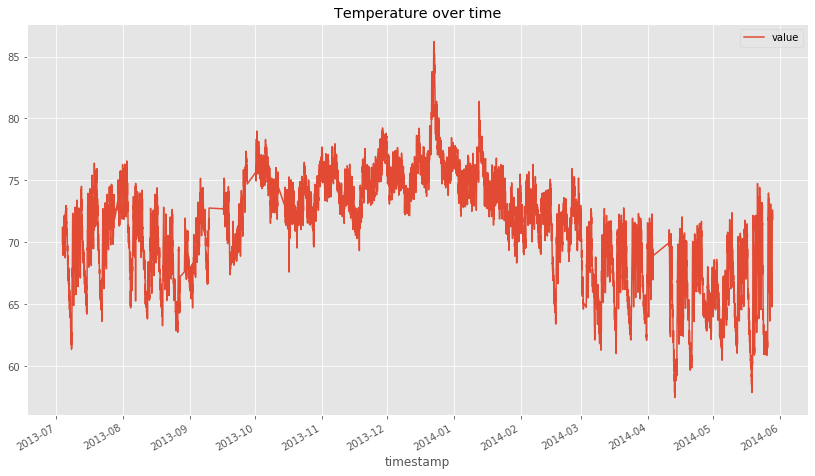

In [16]:
df.plot(figsize=(14,8));
plt.title("Temperature over time");

# 2. Exploratory data analysis

## 2.1 Insights & assumptions

### 2.1.1. discontinuation and missing data 

Notice that there are some discontinuation in time series, which is confirmed by the `infer_freq` below. Expect to see an hourly frequency for the data index should there be no discontinuation.

In [17]:
print(df.index.freq)

None


In [18]:
print(pd.infer_freq(df.index))

None


In [19]:
print(pd.infer_freq(df.head(500).index))

H


**Identify there are 10 discontiuation points in the time series.**

In [20]:
for i in range(0,7266):
    if df.index[i+1] != df.index[i] + pd.DateOffset(hours=1):
        print (df.index[i])

2013-07-28 01:00:00
2013-07-28 04:00:00
2013-08-27 11:00:00
2013-09-09 20:00:00
2013-09-27 12:00:00
2013-10-11 20:00:00
2014-03-02 03:00:00
2014-03-18 02:00:00
2014-03-24 04:00:00
2014-04-03 09:00:00


### 2.1.2 Spike around 2013 Dec


- Prior to spike upward trending
- Post spike another spike 
- Post spike downward trending

**Intuition: an outage in 2013 Dec -> lead to any interventions; another spike in 2-3 months, but afterwards the temp was downward trending could be because of the intervention.**

In [21]:
## It shows the spike happens on Dec 22th, 2013.

df.reset_index().loc[np.argmax(df.value),:]

timestamp    2013-12-22 21:00:00
value                    86.2232
Name: 3722, dtype: object

In [22]:
prior = df.loc[df.index <= pd.to_datetime('2013-12-22'),:]
posterior = df.loc[df.index >= pd.to_datetime('2013-12-22'),:]

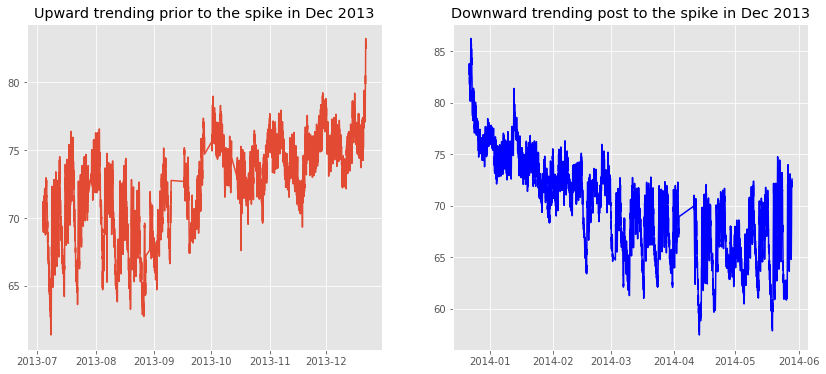

In [23]:
plt.figure(figsize=(14,6))
ax1 = plt.subplot(1,2,1)
ax1.plot(prior.value);
ax2 = plt.subplot(1,2,2)
ax2.plot(posterior.value,color ='blue');
ax1.set_title("Upward trending prior to the spike in Dec 2013");
ax2.set_title("Downward trending post to the spike in Dec 2013");

### 3. Seasonality

I notice there is seasonality in the data so I choose to use the first and last continuous period of data to see if we can decompose seasonality.

It shows there are some seasonality but is not sufficient to explain all variances in the data, as the residual chart still shows unexplained variances especially for the tail part of the data.

In [24]:
rcParams['figure.figsize'] = 18, 8

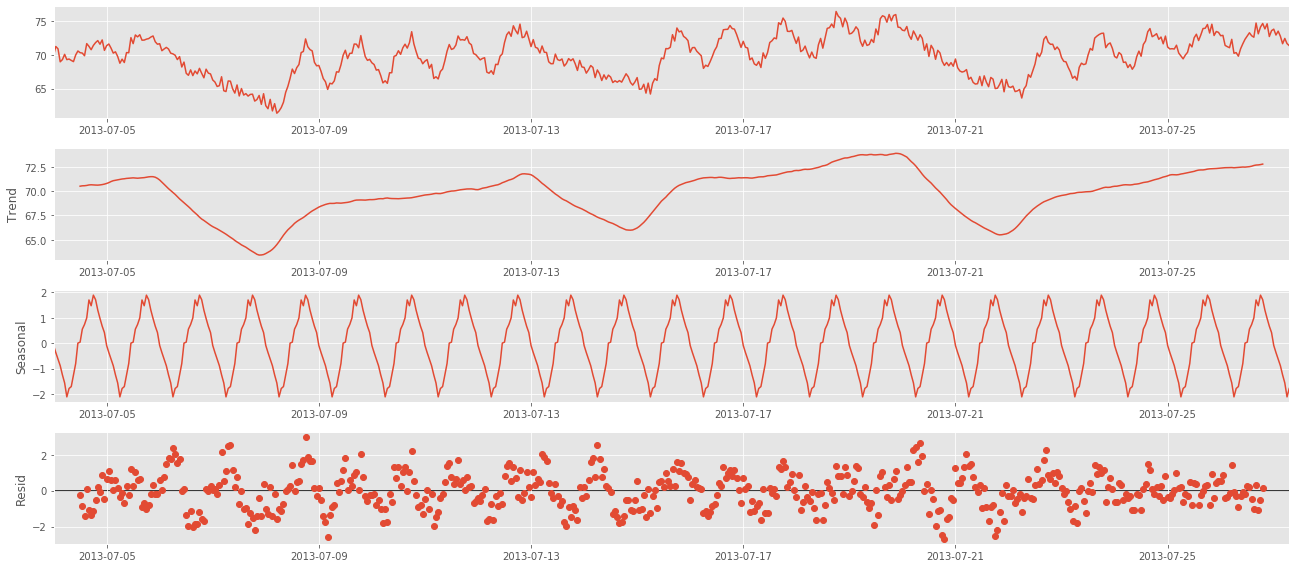

In [25]:
decomposition = sm.tsa.seasonal_decompose(df[:560], model='additive')
fig = decomposition.plot()
plt.show()

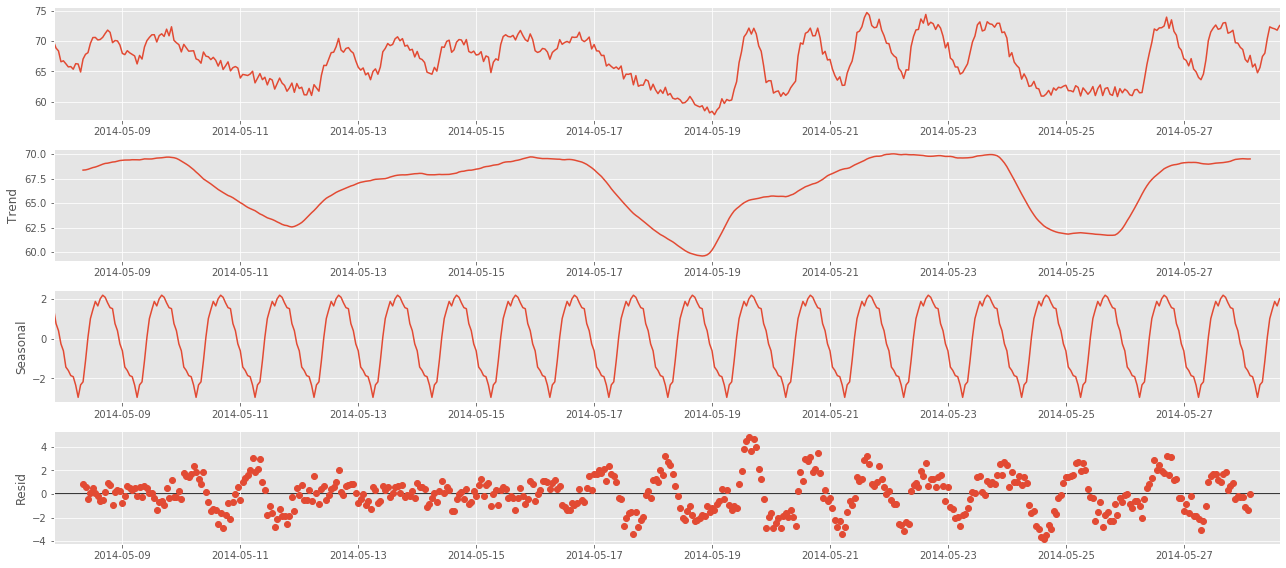

In [26]:
decomposition = sm.tsa.seasonal_decompose(df[-500:], model='additive')
fig = decomposition.plot()
plt.show()

## 2.3. Feature engineering and visualization


### 2.3.1 intuitions & assumptions
Since it's temp, I assume the following will be important:
- **season / quarter**

Considering most scenarios where ambient temperature is important, I assume it is an indoor space (e.g. office buiding, warehouses for delicates, apartment building etc.). I assume the following factors will matter most:
- **weekday vs. weekend**
- **hour of the day**

Assuming majority of the world, especially western world, has holidays in December, this could impact behaviours change in office and apartments.
- **if holiday season (Dec)**

In [27]:
df['day_of_week'] = df.index.dayofweek

In [28]:
df.head()

,value,day_of_week
timestamp,,
2013-07-04 00:00:00,69.880835,3
2013-07-04 01:00:00,71.220227,3
2013-07-04 02:00:00,70.877805,3
2013-07-04 03:00:00,68.959400,3
2013-07-04 04:00:00,69.283551,3


/Users/Liyou/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


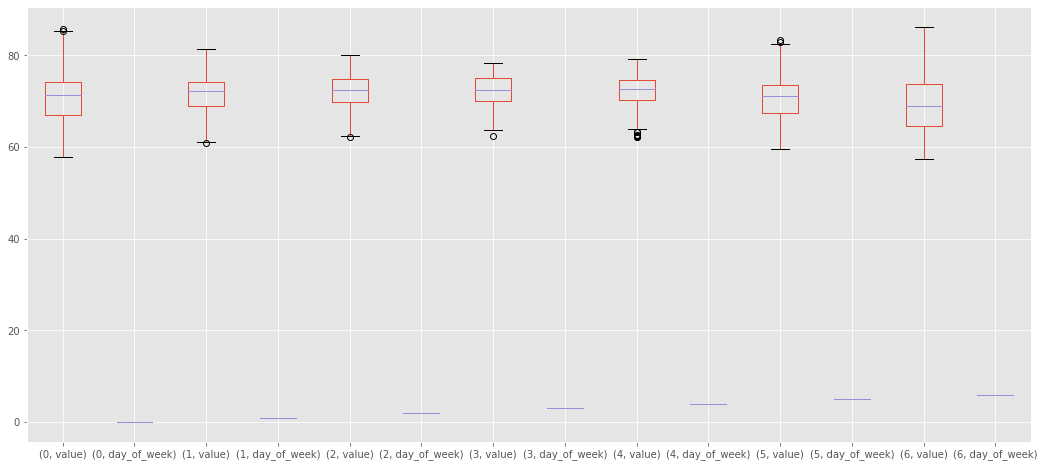

In [29]:
df.groupby(by=['day_of_week']).boxplot(subplots=False);

Notice: 
* Tues to Thu show similiar patters;
* Fri have more low temp outliers
* Sat have more high temp outliers
* Sun and Mon show similiar pattern


In [30]:
df['hour_of_day']= df.index.hour

/Users/Liyou/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


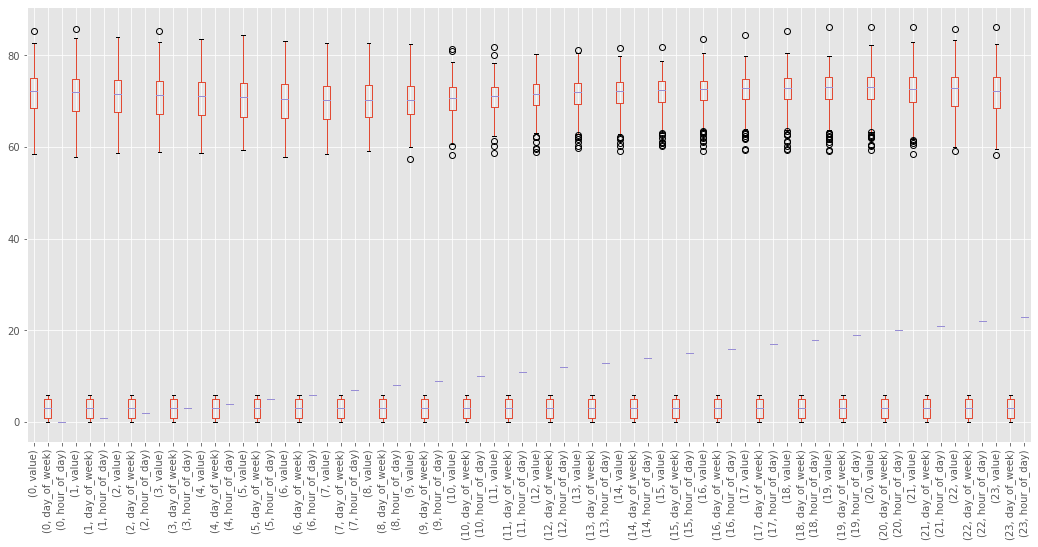

In [31]:
df.groupby(by=['hour_of_day']).boxplot(subplots=False,rot=90);

notice:
* 9am - 9pm are periods where there are most outliers 
* 10pm - 3am shows similiar pattern of more high temp outlier but less low temp outliers
* 4am - 8am are periods where data are most stable

I will use these insights to encode categories later.

In [32]:
df['month'] = df.index.month

/Users/Liyou/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


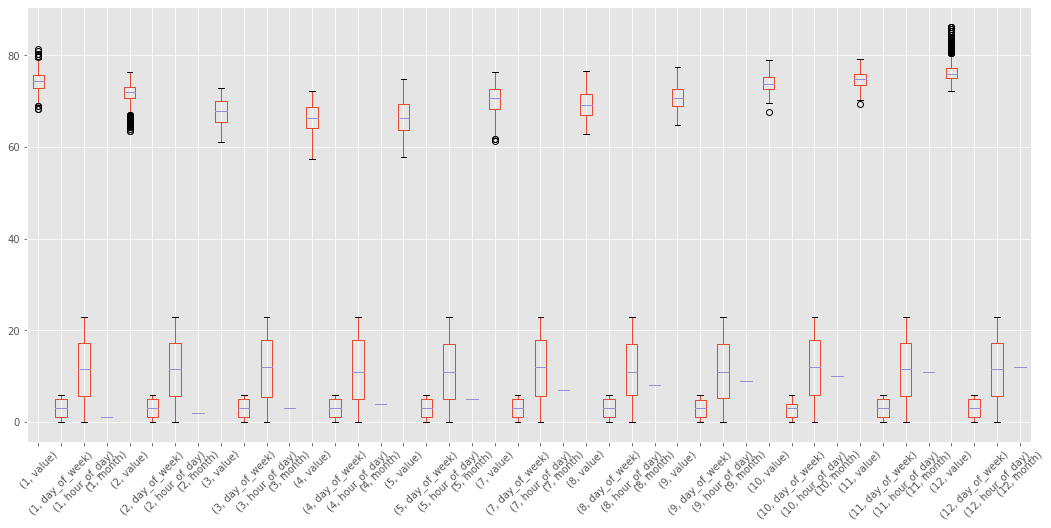

In [33]:
df.groupby(by=['month']).boxplot(subplots=False,rot=45);

Notice:
- **No June data**
- Dec, Jan, Feb shows more outliers
- seasonal trend as months progress through out the year

In [34]:
df['month'].value_counts()

1     744
12    744
11    720
3     699
8     697
2     672
5     664
10    662
7     640
4     547
9     478
Name: month, dtype: int64

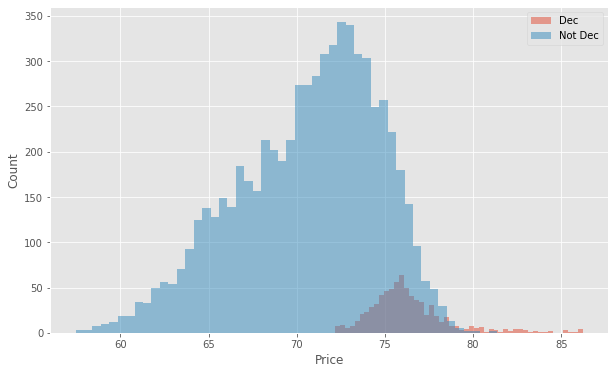

In [35]:
a = df.loc[df['month'] == 12, 'value']
b = df.loc[df['month'] != 12, 'value']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Dec')
plt.hist(b, bins = 50, alpha=0.5, label='Not Dec')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show();

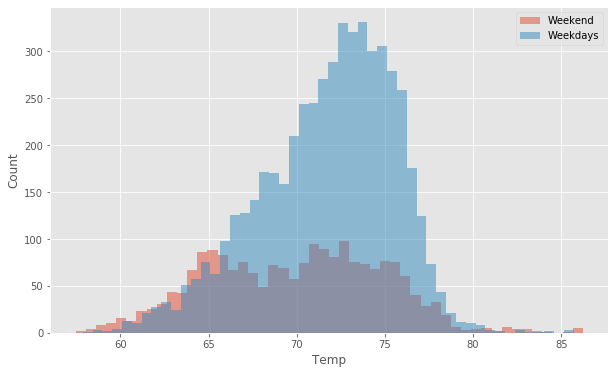

In [36]:
a = df.loc[df['day_of_week'] >= 5, 'value']
b = df.loc[df['day_of_week'] < 5, 'value']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Weekend')
plt.hist(b, bins = 50, alpha=0.5, label='Weekdays')
plt.legend(loc='upper right')
plt.xlabel('Temp')
plt.ylabel('Count')
plt.show();

In [37]:
df.reset_index(inplace=True)

In [38]:
df['quarter'] = df['timestamp'].dt.quarter

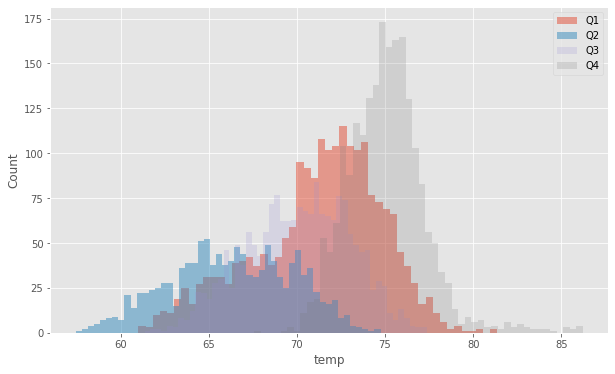

In [39]:
a = df.loc[df['quarter'] == 1, 'value']
b = df.loc[df['quarter'] == 2, 'value']
c = df.loc[df['quarter'] == 3, 'value']
d = df.loc[df['quarter'] == 4, 'value']
plt.figure(figsize=(10, 6))
plt.hist(a, bins = 50, alpha=0.5, label='Q1')
plt.hist(b, bins = 50, alpha=0.5, label='Q2')
plt.hist(c, bins = 50, alpha=0.2, label='Q3')
plt.hist(d, bins = 50, alpha=0.2, label='Q4')
plt.legend(loc='upper right')
plt.xlabel('temp')
plt.ylabel('Count')
plt.show();

In [40]:
df['hour'] = df['hour_of_day'] #make a copy
hours_to_cat = {"hour_of_day":{0:"evening", 1:"evening",2:"evening",3:"evening",4:"early morning",5:"early morning",6:"early morning",
                                 7:"early morning",8:"early morning",9:"day",10:"day",11:"day",12:"day",13:"day",14:"day",15:"day",
                                  16:"day",17:"day",18:"day",19:"day",
                             20:"day",21:"day",22:"evening",23: "evening"
                            }}
df.replace(hours_to_cat, inplace=True);


In [41]:
df['month_cp'] = df['month'] #make a copy
cat = {"month":{1:"Jan",2:"Feb",3:"S",4:"Spring",5:"Spring",
                                 7:"Summer",8:"Summer",9:"Fall",10:"Fall",11:"Fall",12:"Dec"
                            }}
df.replace(cat, inplace=True);


In [42]:
df['day_of_week_cp'] = df['day_of_week'] #make a copy
cat = {"day_of_week":{0:"Monday",1:"weekday",2:"weekday",3:"weekday",4:"Friday",5:"Sat",
                            6:"Sun"
                            }} 
df.replace(cat, inplace=True);


In [43]:
df.head()

,timestamp,value,day_of_week,hour_of_day,month,quarter,hour,month_cp,day_of_week_cp
0,2013-07-04 00:00:00,69.880835,weekday,evening,Summer,3,0,7,3
1,2013-07-04 01:00:00,71.220227,weekday,evening,Summer,3,1,7,3
2,2013-07-04 02:00:00,70.877805,weekday,evening,Summer,3,2,7,3
3,2013-07-04 03:00:00,68.959400,weekday,evening,Summer,3,3,7,3
4,2013-07-04 04:00:00,69.283551,weekday,early morning,Summer,3,4,7,3


In [44]:
def dummify(df, col_list):
    catogories_already_dummified = []
    for col in col_list:
        if df[col].isnull().sum() == 0:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            catogories_already_dummified.append(col)
        else:
            dummies = pd.get_dummies(
                df[col], prefix=col, dummy_na=True, drop_first=True)
            catogories_already_dummified.append(col)
        df[dummies.columns] = dummies

    df = df.drop(catogories_already_dummified, axis=1)
    return df

In [45]:
processed_df = dummify(df,['day_of_week','hour_of_day','month'])
processed_df = processed_df.drop(['timestamp','month_cp','day_of_week_cp','hour','quarter'],axis=1)

In [46]:
processed_df.head()

,value,day_of_week_Monday,day_of_week_Sat,day_of_week_Sun,day_of_week_weekday,hour_of_day_early morning,hour_of_day_evening,month_Fall,month_Feb,month_Jan,month_S,month_Spring,month_Summer
0,69.880835,0,0,0,1,0,1,0,0,0,0,0,1
1,71.220227,0,0,0,1,0,1,0,0,0,0,0,1
2,70.877805,0,0,0,1,0,1,0,0,0,0,0,1
3,68.959400,0,0,0,1,0,1,0,0,0,0,0,1
4,69.283551,0,0,0,1,1,0,0,0,0,0,0,1


# 3. Statistical analysis 

## 3.1 Z-score to define anomaly

I want to use Z-score to explore what percentage of data would we define as abnormal.

In [47]:
df['z_score'] = (df['value'] - df['value'].mean())/df['value'].std(ddof=0)

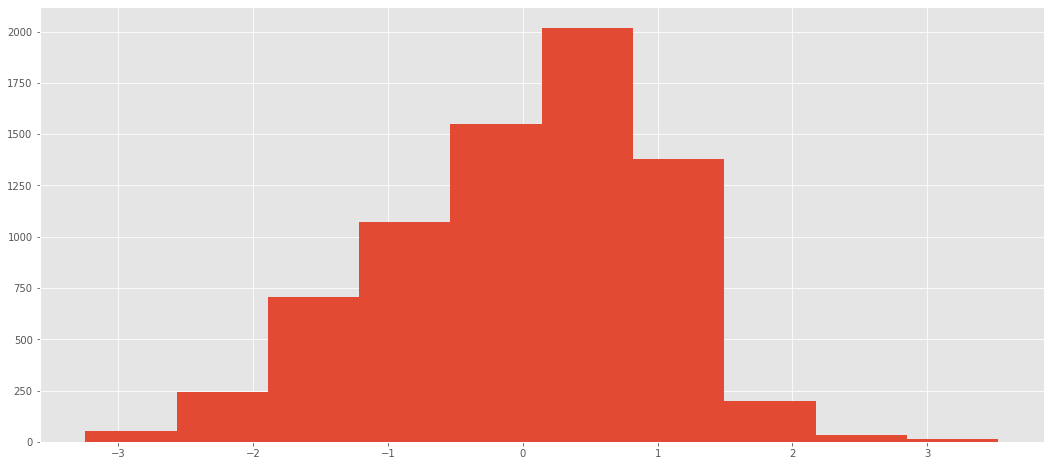

In [48]:
df['z_score'].hist();

I explore 1-3% anomaly percentage to see what does anomaly look like.

In [49]:
for i in np.arange(0.01,0.04,0.01):
    print (df.shape[0] * i)

72.67
145.34
218.01


In [50]:
sum(abs(df['z_score'])>2.58)

75

In [51]:
df['anomaly_1pct'] = abs(df['z_score']) > 2.58

In [52]:
df['anomaly_1pct'].value_counts()

False    7192
True       75
Name: anomaly_1pct, dtype: int64

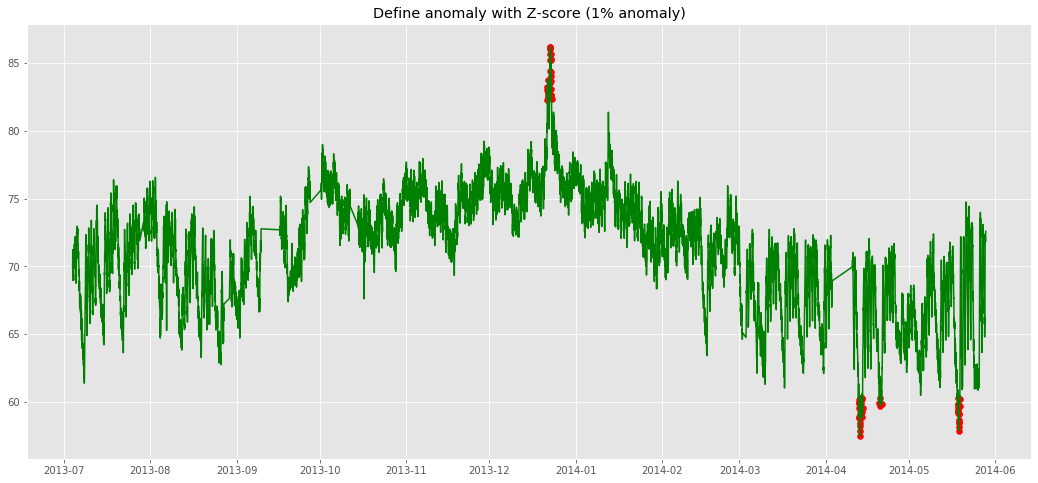

In [53]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_1pct'] == True, ['timestamp', 'value']]

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')

plt.title("Define anomaly with Z-score (1% anomaly)")
plt.show()

In [54]:
sum(abs(df['z_score']) > 2.16)

215

In [55]:
df.shape[0] * 0.03

218.01

In [56]:
df['anomaly_2pct'] = abs(df['z_score']) > 2.24

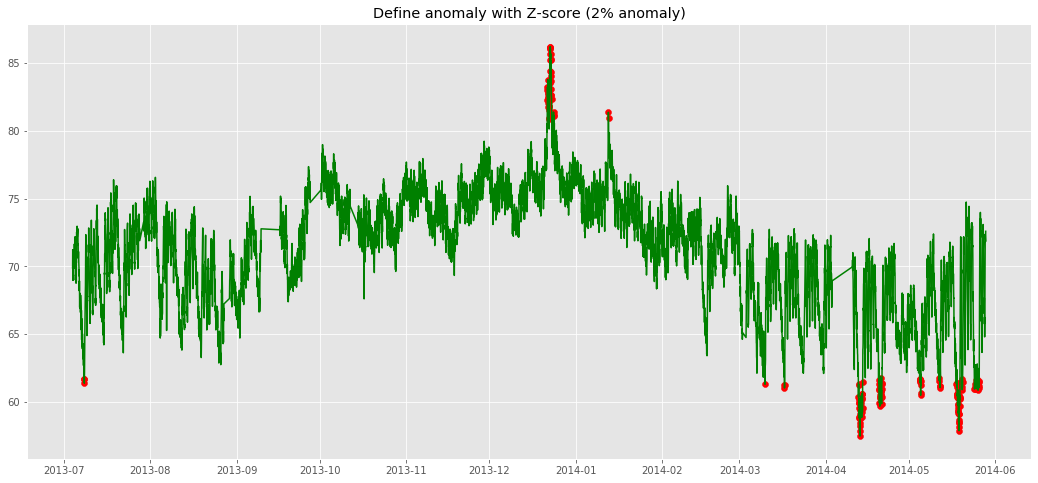

In [57]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_2pct'] == True, ['timestamp', 'value']] 

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')

plt.title("Define anomaly with Z-score (2% anomaly)")
plt.show()

In [58]:
df['anomaly_3pct'] = abs(df['z_score']) > 2.16

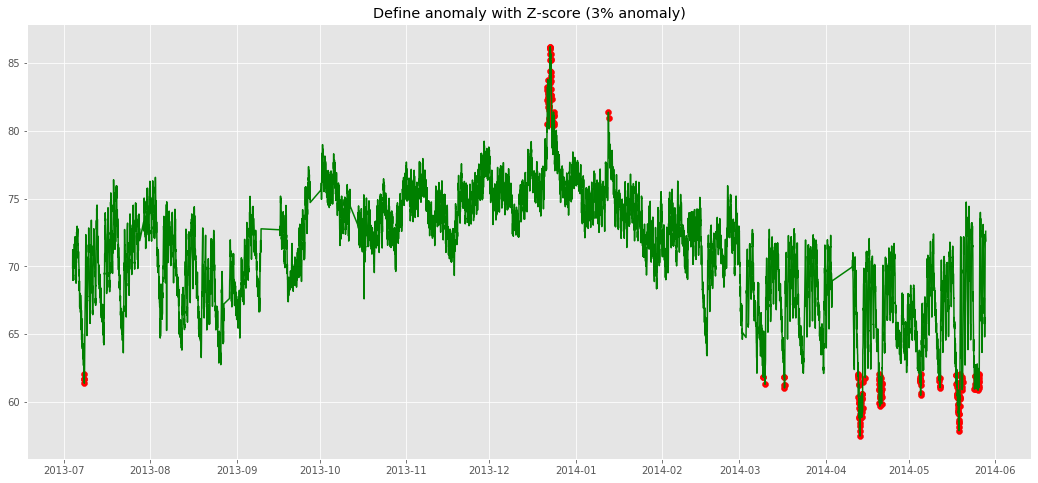

In [59]:
fig, ax = plt.subplots()

a = df.loc[df['anomaly_3pct'] == True, ['timestamp', 'value']] 

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')

plt.title("Define anomaly with Z-score (3% anomaly)")
plt.show()

## 3.2 Pros & Cons

From the chart it shows the pros and cons using Z-score to detect anomaly:

pros:
* intuitive to understand
* easy to implement

cons:
* only consider anomaly in the global context, not able to detect anomaly in local context 


# 4. Clustering modeling

## 4.1 Isolation Forest

In [60]:
## using 1% anomaly as a starting point - can be fine tuned later

anomaly_pct = 0.01

In [61]:
min_max_scaler = StandardScaler()
np_scaled = min_max_scaler.fit_transform(processed_df)
scaled = pd.DataFrame(np_scaled)

In [62]:
scaled = pd.DataFrame(np_scaled)

In [63]:
if_model =  IsolationForest(contamination = anomaly_pct)
if_model.fit(scaled)

IsolationForest(contamination=0.01)

In [64]:
df['IF_pred']  = [1 if i==-1 else 0 for i in pd.Series(if_model.predict(scaled))]

In [65]:
df.head()

,timestamp,value,day_of_week,hour_of_day,month,quarter,hour,month_cp,day_of_week_cp,day_of_week_Monday,day_of_week_Sat,day_of_week_Sun,day_of_week_weekday,hour_of_day_early morning,hour_of_day_evening,month_Fall,month_Feb,month_Jan,month_S,month_Spring,month_Summer,z_score,anomaly_1pct,anomaly_2pct,anomaly_3pct,IF_pred
0,2013-07-04 00:00:00,69.880835,weekday,evening,Summer,3,0,7,3,0,0,0,1,0,1,0,0,0,0,0,1,-0.320586,False,False,False,0
1,2013-07-04 01:00:00,71.220227,weekday,evening,Summer,3,1,7,3,0,0,0,1,0,1,0,0,0,0,0,1,-0.005228,False,False,False,0
2,2013-07-04 02:00:00,70.877805,weekday,evening,Summer,3,2,7,3,0,0,0,1,0,1,0,0,0,0,0,1,-0.085851,False,False,False,0
3,2013-07-04 03:00:00,68.959400,weekday,evening,Summer,3,3,7,3,0,0,0,1,0,1,0,0,0,0,0,1,-0.537536,False,False,False,0
4,2013-07-04 04:00:00,69.283551,weekday,early morning,Summer,3,4,7,3,0,0,0,1,1,0,0,0,0,0,0,1,-0.461215,False,False,False,0


In [66]:
df['IF_pred'].value_counts()

0    7196
1      71
Name: IF_pred, dtype: int64

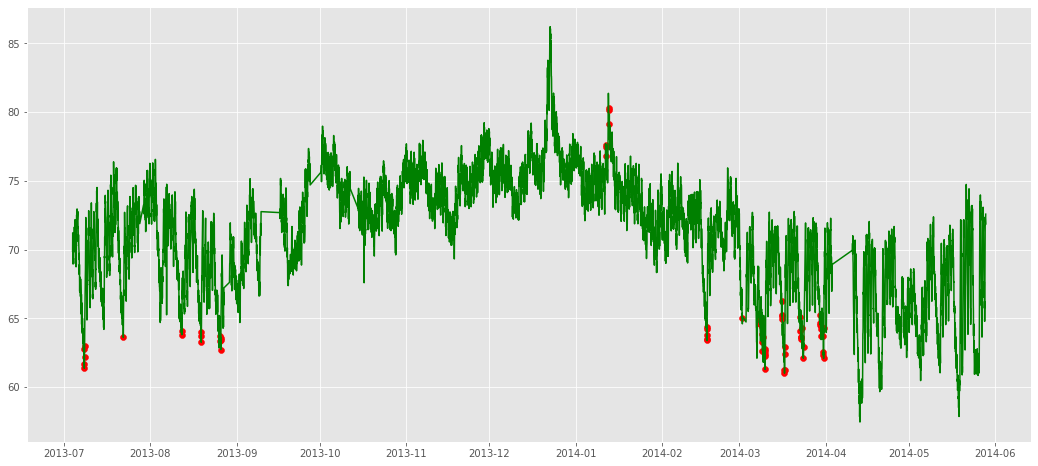

In [67]:
fig, ax = plt.subplots()

a = df.loc[df['IF_pred'] == 1, ['timestamp', 'value']] 

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

## conclusion
The Isolation Forest model was able to detect the low temps however less sensitive to high temp, e.g. cannot detect the spike in Dec 2013.

## 4.2 Single class SVM

In [68]:
svm =  OneClassSVM(nu=0.95 * anomaly_pct) 
svm.fit(scaled)

OneClassSVM(nu=0.0095)

In [69]:
df['svm_pred'] = [1 if i==-1 else 0 for i in pd.Series(svm.predict(scaled))]

In [70]:
df['svm_pred'].value_counts()

0    7191
1      76
Name: svm_pred, dtype: int64

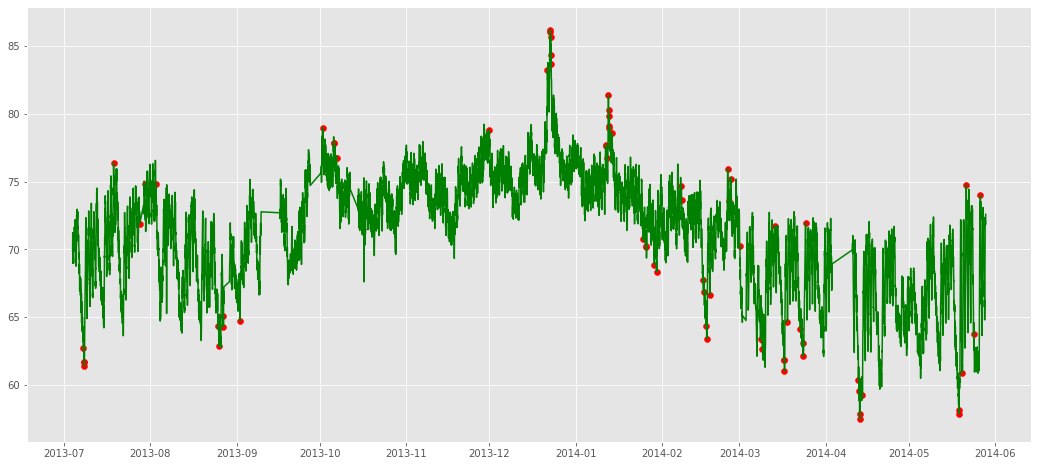

In [71]:
fig, ax = plt.subplots()

a = df.loc[df['svm_pred'] == 1, ['timestamp', 'value']] 

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

### conclusion

* Single class SVM is better performing than Isolation Forest as it is both sensitive to the high temp but also the low temp. 
* It is also learning anomaly at both the global context (dec 2013 spike) and local context (anomalies through out time).

## 4.3 Local Outlier Factor

In [72]:
lof = LocalOutlierFactor(contamination=anomaly_pct, novelty=False)

In [73]:
preds = lof.fit_predict(scaled)

In [74]:
pd.Series(preds).value_counts()

 1    7194
-1      73
dtype: int64

In [75]:
df['lof_pred'] = [1 if i==-1 else 0 for i in pd.Series(preds)]

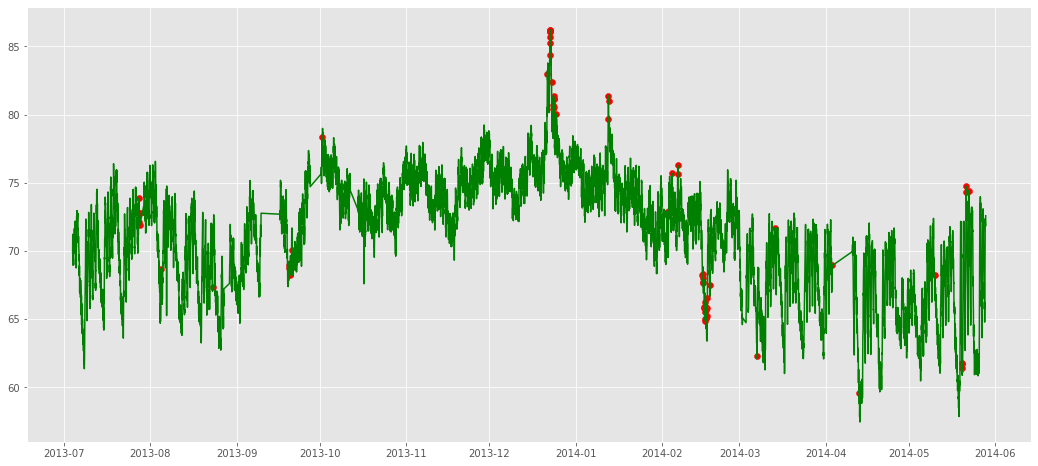

In [76]:
fig, ax = plt.subplots()

a = df.loc[df['lof_pred'] == 1, ['timestamp', 'value']] 

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

### conclusion

* Local Outlier Factor is not performing as well as single class SVM as the anomaly as they are heavily focused on two spikes.
* There are also anomaly points that are not picked up well by LOF model.


## 4.4 PCA + Kmeans

In [77]:
processed_df.head()

,value,day_of_week_Monday,day_of_week_Sat,day_of_week_Sun,day_of_week_weekday,hour_of_day_early morning,hour_of_day_evening,month_Fall,month_Feb,month_Jan,month_S,month_Spring,month_Summer
0,69.880835,0,0,0,1,0,1,0,0,0,0,0,1
1,71.220227,0,0,0,1,0,1,0,0,0,0,0,1
2,70.877805,0,0,0,1,0,1,0,0,0,0,0,1
3,68.959400,0,0,0,1,0,1,0,0,0,0,0,1
4,69.283551,0,0,0,1,1,0,0,0,0,0,0,1


In [78]:
scaled.shape

(7267, 13)

In [79]:
def PCA_reduce(X,dimensionality):
    '''[summary]
    reduced n dimensionality matrix and np array of important features
    Arguments:
        X {[numpy matrix]} -- input matrix
        dimensionality {[int]} -- to what dimensionality to reduce to
    Returns:
        X_reduced -- reduced matrix
        important_features -- a list of features that contributed most to the principle component
    '''

    important_features = []
    pcd = PCA(dimensionality).fit(X)
    pca_matrix = pcd.components_
    for i in range(dimensionality):
        print('#{} Principle Component top 5 contributors are:'.format(i), np.argsort(np.abs(pca_matrix[i,:]))[-5:])
        important_features.append(np.argsort(np.abs(pca_matrix[i,:]))[-3:])
    X_reduced = np.dot(X,pcd.components_.T)
    print('Reduced X shape:', X_reduced.shape)
    important_features = np.array(important_features)
    print('Explained variance:', pcd.explained_variance_)
    print('Explained variance ratio:', pcd.explained_variance_ratio_)
    print('Explained variance ratio accumulated:', pcd.explained_variance_ratio_.cumsum())
    return X_reduced, important_features

In [80]:
important_features = []
pcd = PCA(12).fit(scaled)
pca_matrix = pcd.components_
for i in range(12):
    print('#{} Principle Component top 5 contributors are:'.format(i), np.argsort(np.abs(pca_matrix[i,:]))[-5:])
    important_features.append(np.argsort(np.abs(pca_matrix[i,:]))[-3:])
re_X_ww = np.dot(scaled,pcd.components_.T)
print('Reduced X shape:', re_X_ww.shape)

imp_f_ww = np.array(important_features)
print('Explained variance:', pcd.explained_variance_)
print('Explained variance ratio:', pcd.explained_variance_ratio_)
print('Explained variance ratio accumulated:', pcd.explained_variance_ratio_.cumsum())


#0 Principle Component top 5 contributors are: [10  4  7 11  0]
#1 Principle Component top 5 contributors are: [ 3 11  1  2  4]
#2 Principle Component top 5 contributors are: [ 4 12  7  5  6]
#3 Principle Component top 5 contributors are: [ 9  2 11  7 12]
#4 Principle Component top 5 contributors are: [ 2  8 12  7  9]
#5 Principle Component top 5 contributors are: [12 10  2  3  1]
#6 Principle Component top 5 contributors are: [11 10 12  2  3]
#7 Principle Component top 5 contributors are: [ 2  8  9 11 10]
#8 Principle Component top 5 contributors are: [ 1  2 10  9  8]
#9 Principle Component top 5 contributors are: [ 9 11  0  5  6]
#10 Principle Component top 5 contributors are: [ 8 11  9  7  0]
#11 Principle Component top 5 contributors are: [7 1 2 3 4]
Reduced X shape: (7267, 12)
Explained variance: [1.92540438 1.43195852 1.29597253 1.25137174 1.18210691 1.16289508
 1.15579257 1.12074743 1.10386851 0.71047168 0.38940422 0.20163423]
Explained variance ratio: [0.14808765 0.1101355  0.0

In [81]:
imp_f_ww

array([[ 7, 11,  0],
       [ 1,  2,  4],
       [ 7,  5,  6],
       [11,  7, 12],
       [12,  7,  9],
       [ 2,  3,  1],
       [12,  2,  3],
       [ 9, 11, 10],
       [10,  9,  8],
       [ 0,  5,  6],
       [ 9,  7,  0],
       [ 2,  3,  4]])

Text(0, 0.5, 'Accumulated Explained Variance')

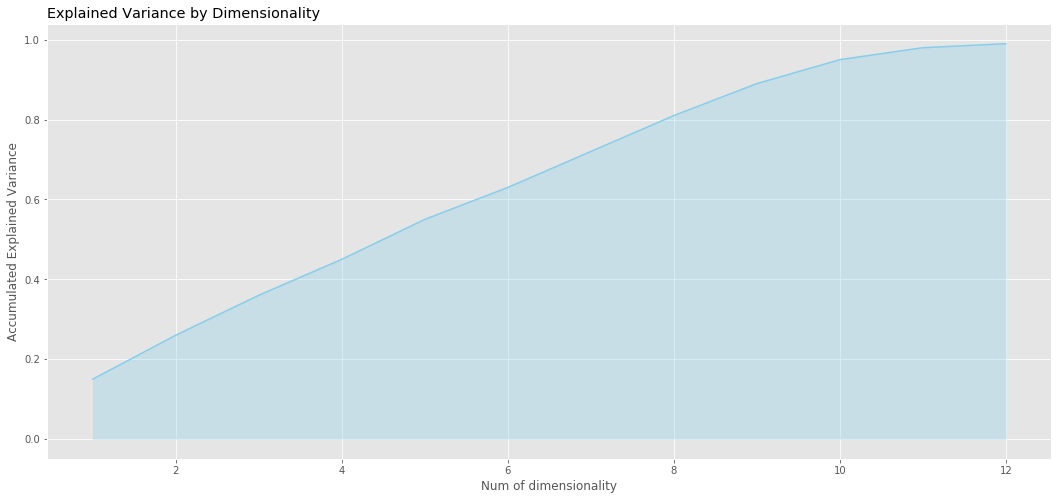

In [82]:
# Plot explained variance by dimensionality
x = range(1,13)
y = np.round(pcd.explained_variance_ratio_.cumsum(),2)
plt.fill_between(x, y, color="skyblue", alpha=0.3)
plt.plot(x, y, color="skyblue")
 
# Add titles and labels
plt.title("Explained Variance by Dimensionality", loc="left");
plt.xlabel("Num of dimensionality")
plt.ylabel("Accumulated Explained Variance")

In [83]:
pcd = PCA(8).fit(scaled)

In [84]:
re_X_ww = re_X_ww[:,:8]

In [85]:
def print_imp_features(df,imp_features):
    '''[summary]
    print important features names and return the counter of the features
    Arguments:
        df {[pandas dataframe]} -- input
        imp_features {[list]} -- important features returned from pca_reduce function
    Returns:
        counter [dictionary] -- a dictionary with feature name as key, and frequency showed as value 
    '''

    feature = []
    idx = 0
    c = 1
    while idx < len(np.array(imp_features).flatten()):
        print('#{} PC:'.format(c))
        if idx+3 > len(np.array(imp_features).flatten()):
            for i in np.array(imp_features).flatten()[idx:]:
                feature.append(list(df.columns)[i])
                print(list(df.columns)[i])
        else:
            for i in np.array(imp_features).flatten()[idx:idx+3]:
                feature.append(list(df.columns)[i])
                print(list(df.columns)[i])
        idx += 3
        c +=1
    counter = Counter(feature)
    return counter

In [86]:
# print out top 5 contributers for each principle component to understand what features are providing signals
counter = print_imp_features(processed_df,imp_f_ww[:8,:])

#1 PC:
month_Fall
month_Spring
value
#2 PC:
day_of_week_Monday
day_of_week_Sat
day_of_week_weekday
#3 PC:
month_Fall
hour_of_day_early morning
hour_of_day_evening
#4 PC:
month_Spring
month_Fall
month_Summer
#5 PC:
month_Summer
month_Fall
month_Jan
#6 PC:
day_of_week_Sat
day_of_week_Sun
day_of_week_Monday
#7 PC:
month_Summer
day_of_week_Sat
day_of_week_Sun
#8 PC:
month_Jan
month_Spring
month_S


In [87]:
def kmeans_cluster(X_reduced,cluster_num):
    '''[summary]
    use kmeans++ algorithems to cluster input data.
    Arguments:
        X_reduced {[numpy matrix]} -- input matrix
        cluster_num {[int]} -- how many clusters for clustering 
    Returns:
        y[numpy array] -- assigned_cluster for each row
        centers[numpy matrix] -- centers of the clusters
    '''

    kmeans = KMeans(init='k-means++', n_clusters=cluster_num, n_init=10,tol=0.0001,verbose=0)
    y = kmeans.fit_predict(X_reduced)
    centers = kmeans.cluster_centers_
    # assigned_cluster = kmeans.transform(X_reduced).argmin(axis=1)
    return y, centers

**Choosing 17 clusters using Elbow method**

In [88]:
n_clusters = []
scores =[]
for i in range(2,20):
    y,centers = kmeans_cluster(scaled,i)
#     print (silhouette_score(re_X_ww,y,sample_size = 7000))
    scores.append(silhouette_score(re_X_ww,y,sample_size = 7000))
    n_clusters.append(i)

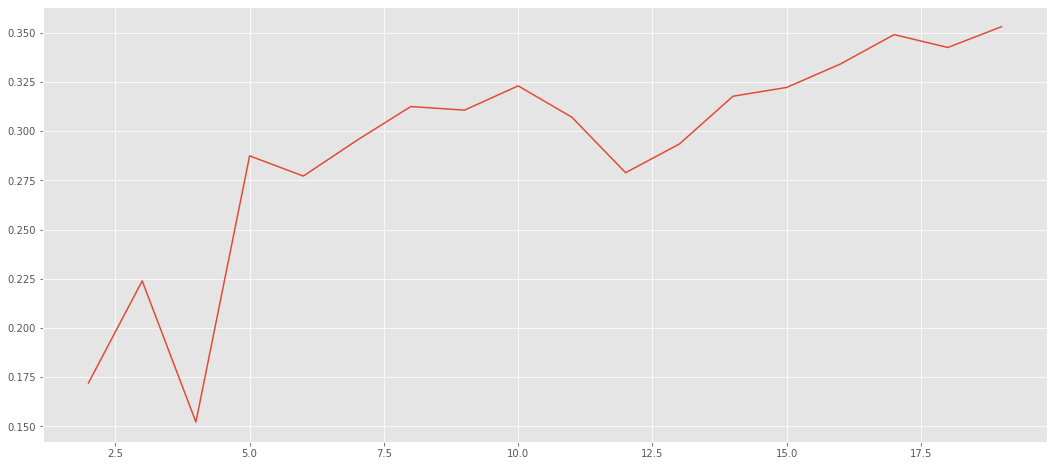

In [89]:
fig, ax = plt.subplots()
ax.plot(n_clusters, scores)
plt.show()

In [90]:
y,centers = kmeans_cluster(scaled,18)

In [91]:
def count_rows(x):
    return len(x)

In [92]:
df['kmeans_cluster'] = y

In [93]:
df.groupby('kmeans_cluster').apply(count_rows) * 1.0 /df.shape[0]

kmeans_cluster
0     0.049539
1     0.038530
2     0.025458
3     0.044035
4     0.046236
5     0.102381
6     0.092473
7     0.044448
8     0.024770
9     0.051466
10    0.094950
11    0.096188
12    0.105821
13    0.029723
14    0.023118
15    0.023118
16    0.084079
17    0.023669
dtype: float64

In [94]:
df[['value','kmeans_cluster','timestamp']]

,value,kmeans_cluster,timestamp
0,69.880835,12,2013-07-04 00:00:00
1,71.220227,12,2013-07-04 01:00:00
2,70.877805,12,2013-07-04 02:00:00
3,68.959400,12,2013-07-04 03:00:00
4,69.283551,12,2013-07-04 04:00:00
...,...,...,...
7262,72.370206,10,2014-05-28 11:00:00
7263,72.172956,10,2014-05-28 12:00:00
7264,72.046565,10,2014-05-28 13:00:00
7265,71.825226,10,2014-05-28 14:00:00


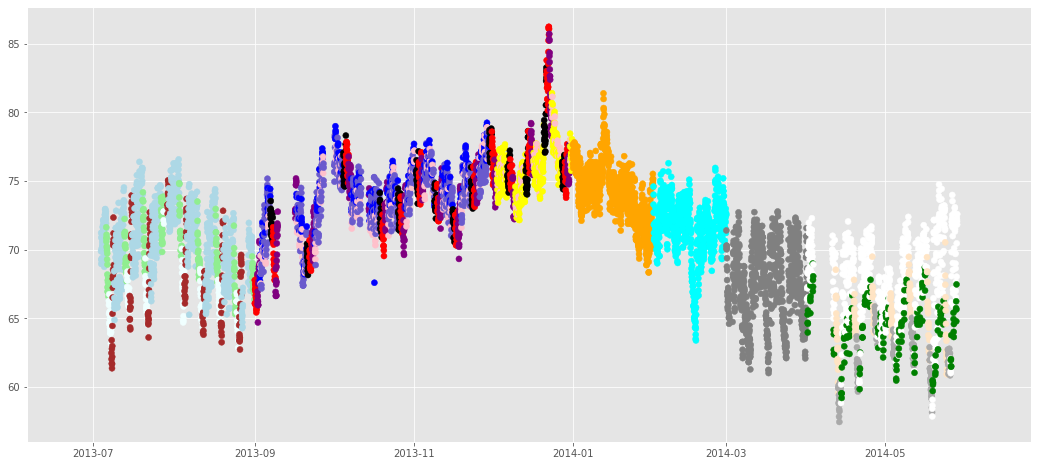

In [95]:
fig, ax = plt.subplots()

colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey',15:'bisque',16:'slateblue',17:'azure'}
ax.scatter(df['timestamp'], df['value'], c=df["kmeans_cluster"].apply(lambda x: colors[x]))

# a = df.loc[df['lof_pred'] == 1, ['timestamp', 'value']] 

# ax.plot(df['timestamp'], df['value'], color='green')
# ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

### conclusion

* There is no cluster that can include or represent all global anomalies
* **Next development required: Since there is no cluster that capture anomalies, I can also use with-in cluster anomalies to identify global anomalies. It will require more development on this model to calculate distance of each point from cluster centroids.**
* Overall, Kmeans + PCA is not as well performing as single class SVM.

# 5. Classfication model

## 5.1 Define labels

### 5.1.1 Approach  & Assumptions

There are three approaches here I can use to define anomalies label:
* **using anomaly points** -- anything in anomaly periods are anomalies

* **using Z-score** -- refer to section 3 statisticaly analysis

* **using both z-score and anomaly periods** -- This is a most well-thought approach


**I'll use Z-score approach here for illustration purpose and choosing 3% as the fraction due to the sample size. In ideal situation without time constraint, I'll use z-score + anomaly periods to define anomalies.**

## 5.2 under sampling due to imbalanced data



In [96]:
df_sample = df.sample(frac=1)

# amount of fraud classes 492 rows.
ano_df = df_sample.loc[df['anomaly_3pct'] == True]
non_ano_df = df_sample.loc[df['anomaly_3pct'] == False][:645] ## 215*3 -> so we have 1:4 ratio for anomaly vs non-anomaly

normal_distributed_df = pd.concat([ano_df, non_ano_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,timestamp,value,day_of_week,hour_of_day,month,quarter,hour,month_cp,day_of_week_cp,day_of_week_Monday,day_of_week_Sat,day_of_week_Sun,day_of_week_weekday,hour_of_day_early morning,hour_of_day_evening,month_Fall,month_Feb,month_Jan,month_S,month_Spring,month_Summer,z_score,anomaly_1pct,anomaly_2pct,anomaly_3pct,IF_pred,svm_pred,lof_pred,kmeans_cluster
5959,2014-03-27 23:00:00,69.612398,weekday,evening,S,1,23,3,3,0,0,0,1,0,1,0,0,0,1,0,0,-0.383789,False,False,False,0,0,0,11
321,2013-07-17 09:00:00,70.277061,weekday,day,Summer,3,9,7,2,0,0,0,1,0,0,0,0,0,0,0,1,-0.227295,False,False,False,0,0,0,12
6176,2014-04-13 05:00:00,59.410747,Sun,early morning,Spring,2,5,4,6,0,0,1,0,1,0,0,0,0,0,1,0,-2.785750,True,True,True,0,0,0,14
7181,2014-05-25 02:00:00,61.819999,Sun,evening,Spring,2,2,5,6,0,0,1,0,0,1,0,0,0,0,1,0,-2.218496,False,False,True,0,0,0,14
6639,2014-05-02 12:00:00,66.348444,Friday,day,Spring,2,12,5,4,0,0,0,0,0,0,0,0,0,0,1,0,-1.152281,False,False,False,0,0,0,10


In [97]:
new_df.shape

(860, 29)

In [98]:
new_df['anomaly_3pct'].value_counts()

False    645
True     215
Name: anomaly_3pct, dtype: int64

## 5.3 model comparison

Compare common classification models with grid search on hyper parameter tuning

In [99]:
y = new_df['anomaly_3pct']

In [100]:
processed_new_df = dummify(new_df,['day_of_week','hour_of_day','month'])

In [101]:
processed_new_df = processed_new_df.drop(['timestamp','month_cp','day_of_week_cp','hour','quarter',
                                          'z_score','anomaly_1pct','anomaly_2pct','anomaly_3pct'
                                         ,'IF_pred','svm_pred','lof_pred','quarter',
                                         'value','kmeans_cluster'],axis=1)

In [102]:
processed_new_df.head()

,day_of_week_Monday,day_of_week_Sat,day_of_week_Sun,day_of_week_weekday,hour_of_day_early morning,hour_of_day_evening,month_Fall,month_Feb,month_Jan,month_S,month_Spring,month_Summer
5959,0,0,0,1,0,1,0,0,0,1,0,0
321,0,0,0,1,0,0,0,0,0,0,0,1
6176,0,0,1,0,1,0,0,0,0,0,1,0
7181,0,0,1,0,0,1,0,0,0,0,1,0
6639,0,0,0,0,0,0,0,0,0,0,1,0


In [103]:
min_max_scaler = StandardScaler()
new_scaled = min_max_scaler.fit_transform(processed_new_df)
new_scaled = pd.DataFrame(new_scaled)

In [104]:
X_train, X_test, y_train, y_test = train_test_split(new_scaled, y, test_size=0.33, random_state=42)

In [105]:
y_test.value_counts()

False    209
True      75
Name: anomaly_3pct, dtype: int64

In [106]:
y_train.value_counts()

False    436
True     140
Name: anomaly_3pct, dtype: int64

In [107]:
def logisticModel(Xtrain, ytrain, X_test):
    # logReg = LogisticRegression()
    # fitted = logReg.fit(X, y)
    # predictedLogistic = cross_val_predict(LogisticRegression(), Xtrain, ytrain, cv=3,method='predict_proba')[:,1]
    lg = LogisticRegression()
    fit = lg.fit(Xtrain,ytrain)
    predictedLogistic = fit.predict_proba(X_test)[:,1]
    return predictedLogistic

In [108]:
predictedLogistic = logisticModel(X_train, y_train, X_test)

In [109]:
def randomForestModel(Xtrain, ytrain,X_test):
    parameters = {'class_weight':['balanced', None],
                'max_depth': [2,4],
                'max_features': ['auto',4,5]
                }
    gscv = GridSearchCV(RandomForestClassifier(), parameters)
    fit = gscv.fit(Xtrain, ytrain)
    print('Best parameters for RF: {}'.format(fit.best_params_))
    predictedRF = fit.predict_proba(X_test)[:,1]
    return predictedRF

In [110]:
predictedRF = randomForestModel(X_train, y_train, X_test)

Best parameters for RF: {'class_weight': None, 'max_depth': 4, 'max_features': 'auto'}


In [111]:
def GradientBoost(Xtrain, ytrain,X_test):
    parameters = {'learning_rate':[0.5,1.0],
                    'n_estimators':  [200,300]
                    }
    decisionTree = GradientBoostingClassifier()
    gscv = GridSearchCV(decisionTree, parameters,scoring = 'roc_auc')
    fit = gscv.fit(Xtrain, ytrain)
    print('Best parameters for GBM: {}'.format(fit.best_params_))
    predictedGradient = fit.predict_proba(X_test)[:,1]
    return fit,predictedGradient

In [112]:
fit_gb, predictedGradient = GradientBoost(X_train, y_train, X_test)

Best parameters for GBM: {'learning_rate': 0.5, 'n_estimators': 200}


In [113]:
def GBC_Logistic(X_train,y_train,X_test):
    X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train,
                                                            y_train,
                                                            test_size=0.5)
    grd = GradientBoostingClassifier(n_estimators=200,learning_rate=0.5)
    grd_enc = OneHotEncoder()
    grd_lm = LogisticRegression()
    grd.fit(X_train, y_train)
    grd_enc.fit(grd.apply(X_train)[:, :, 0])
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
    y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
    return y_pred_grd_lm
    # fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)

In [114]:
predicted_G_L = GBC_Logistic(X_train,y_train,X_test)

/Users/Liyou/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [115]:
# Plot the ROC curves for different models

print("$ ROC Curves")
fpr_l, tpr_l, thresholds_l = roc_curve(y_test, predictedLogistic)
auc_score_l = auc(fpr_l, tpr_l)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, predictedRF)
auc_score_rf = auc(fpr_rf, tpr_rf)
fpr_g, tpr_g, thresholds_g = roc_curve(y_test, predictedGradient)
auc_score_g = auc(fpr_g, tpr_g)
fpr_g_l, tpr_g_l, thresholds_g_l = roc_curve(y_test, predicted_G_L)
auc_score_g_l = auc(fpr_g_l, tpr_g_l)


$ ROC Curves


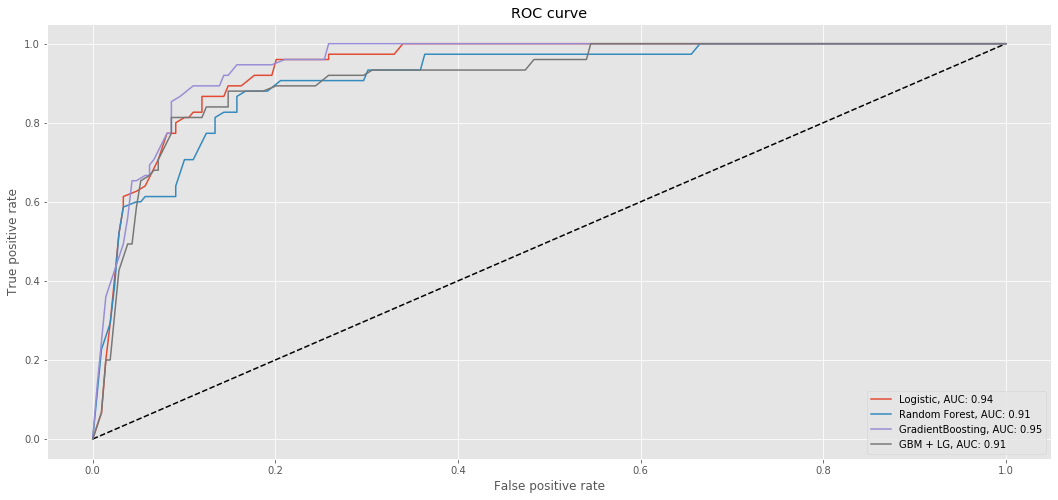

In [116]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_l, tpr_l, label= ('Logistic, AUC: {0:.2f}'.format(auc_score_l)))
plt.plot(fpr_rf, tpr_rf, label=('Random Forest, AUC: {0:.2f}'.format(auc_score_rf)))
plt.plot(fpr_g, tpr_g, label=('GradientBoosting, AUC: {0:.2f}'.format(auc_score_g)))
plt.plot(fpr_g_l, tpr_g_l, label=('GBM + LG, AUC: {0:.2f}'.format(auc_score_g_l)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show();
#         plt.savefig('{} roc.png'.format(n_days))
#         plt.close()



### Model selection 

Overall the models are similiar performing with AUC. 

However, since we are using it for anomaly detection -- we are more looking for models that are robust and are sensitivie enough to pick up True Positives.

### Threashold selection using cost benefit analysis

I'm assigning a benefit of `$20` for successfully identify a True Positive (anomaly), and a cost of `-$20` for missing an anomaly.

In [117]:
def standard_confusion_matrix(y_true, y_pred):
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def profit_curve(cost_benefit, predicted_probs, labels):
    n_obs = float(len(labels))
    thresholds = np.arange(0,1,0.01)
    profits = []
    for threshold in thresholds:
        y_predict = predicted_probs >= threshold
        confusion_matrix = standard_confusion_matrix(labels, y_predict)
        threshold_profit = np.sum(confusion_matrix * cost_benefit) / n_obs
        profits.append([threshold_profit,threshold])
    return profits


In [118]:
def plot_model_profits(profits, save_path=None, n_days=''):
    threshold = []
    profit = []
    for p in profits:
        threshold.append(p[1])
        profit.append(p[0])
    plt.figure(figsize=(4,3))
    plt.plot(threshold, profit)
    plt.ylim(0,8.5)
    plt.title("{} Profit Curve".format(n_days))
    plt.xlabel("TPR-FPR Threshold")
    plt.ylabel("Profit ($/user)")
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [119]:
cost_benefit = np.array([[20, -20], [0, 0]])
profits = profit_curve(cost_benefit,predictedGradient,y_test)
max_profit = max(profits)[0]
max_threshold = max(profits)[1]
print(max_profit, max_threshold)


3.23943661971831 0.45


confusion matrix [[ 64  18]
 [ 11 191]]
profit 3.23943661971831


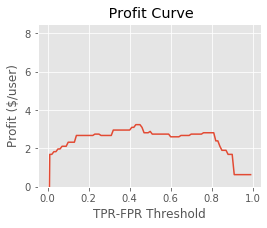

In [120]:
y_predict = predictedGradient >= max_threshold
confusion_matrix = standard_confusion_matrix(y_test,y_predict)
print('confusion matrix',confusion_matrix)
threshold_profit = np.sum(confusion_matrix * cost_benefit) / y_test.shape[0]
print('profit',threshold_profit)

plot_model_profits(profits)

### Using optimal threashold to predict whole data set anomalies

In [121]:
processed_df.drop(['value'],axis=1,inplace=True)

In [122]:
processed_df.head()

,day_of_week_Monday,day_of_week_Sat,day_of_week_Sun,day_of_week_weekday,hour_of_day_early morning,hour_of_day_evening,month_Fall,month_Feb,month_Jan,month_S,month_Spring,month_Summer
0,0,0,0,1,0,1,0,0,0,0,0,1
1,0,0,0,1,0,1,0,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,0,1
3,0,0,0,1,0,1,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,0,1


In [123]:
min_max_scaler = StandardScaler()
ca_scaled = min_max_scaler.fit_transform(processed_df)
ca_scaled = pd.DataFrame(ca_scaled)

In [124]:
df['gb_pred_prob'] = fit_gb.predict_proba(ca_scaled)[:,1]

In [125]:
df['gb_pred'] = df['gb_pred_prob'] > max_threshold

In [126]:
df['gb_pred'].value_counts()

False    6569
True      698
Name: gb_pred, dtype: int64

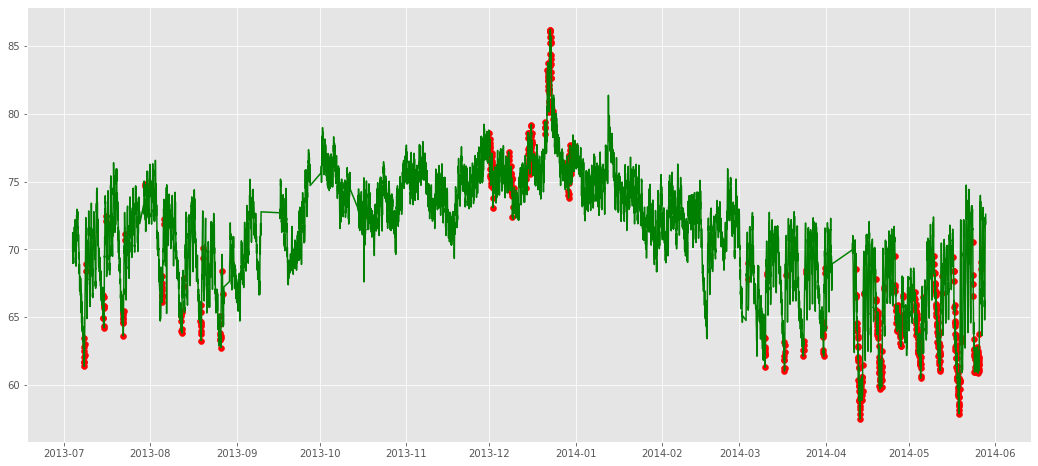

In [127]:
fig, ax = plt.subplots()

a = df.loc[df['gb_pred'] == True, ['timestamp', 'value']] 

ax.plot(df['timestamp'], df['value'], color='green')
ax.scatter(a['timestamp'],a['value'], color='red')
plt.show()

### conclusion

* Using Classfication model to predict 3% of anomaly data points, the model is able to detect both the high and low temp anomalies.


# 5. Conclusion & Recommendations


## 5.1 Summary

### 1) Anomaly definition depends on the business impact
* In this notebook, I'm using Z-score definition as an assumption
* However, anomaly points, or discontinution periods can also be particular impactful.

###  2) Single Class SVM performs best in general context
* Both sensitive to high and low temperature
* Both sensitive to global and local anomalies

### 3) With specific business inputs, classfication models can be used to fine tune the model sensitivity to particular outliers we are interested in.
* Anomaly labels can be encoded in both z-score and discontiuation points.
* Cost benefit analysis offers best threshold given the business assumptions.

### 4) Features about hours, seasons, day of the week are strong predictors of the temperature.
* Some models can offer addition feature importance insights


## 5.2 Use case

### 1) The selected model can be deployed on streaming data to monitor anomalies alert
* This could impact model selection which are suitable for online learning
* Retrain period can be based on business case

### 2) Models can be fine tuned based on business cases 
* For example, different needs of temp monitor at different time/season

## 5.3 Next steps 
Given more development time, here are a list of things that can be improved:

### 1) Feature engineering and extraction
* There are more information can be extracted that could be strong predictors

### 2) Anomaly defintion 
* Expand from Z-score definition 

### 3) Ensemble models (prior and post spike)
* One of the insights is that temp shows distinct trends prior and post spike in Dec 2013, it is also worth exploring if separate into two models can be more accurate to learn the pattern post a potential human intervention. 



